# MISURE CON ACQUA

In [48]:
import pandas as pd
import numpy as np
import os

dir_path = os.path.abspath('') #os.path.dirname(os.path.realpath(__file__))
FILE = dir_path + '/CSV/acqua_dati.csv'
fr = pd.read_csv(FILE)

p1 = np.array(fr['p1']) * 1000 # kPa -> Pa
p2 = np.array(fr['p2']) * 1000
p3 = np.array(fr['p3']) * 1000
p4 = np.array(fr['p4']) * 1000

sigmaY = 0.01 * 1000 # sensibilità strumento di misura

R = np.array(fr['R']) # m^3/s calcolato con excel

R2 = R**2
rho = 1000 # Kg/m3 assunto anche nel file excel

## calcolo velocità:

$R = cost = A_Lv_L = A_sv_s$

vL:  [0.11859296 0.1638191  0.2080402  0.23517588 0.28994975]
vs:  [0.52212389 0.72123894 0.9159292  1.03539823 1.27654867]


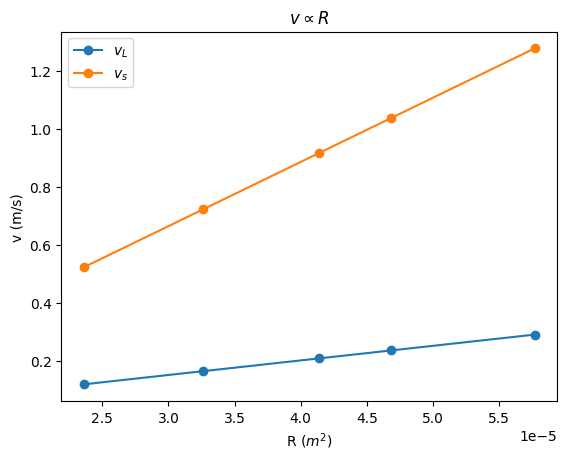

In [49]:
import matplotlib.pyplot as plt

AL = 1.99 / 10000 # m2
AS = 0.452 / 10000 # m2

vL = R / AL
vs = R / AS

print('vL: ',vL)
print('vs: ', vs)

plt.title('$v \propto R$')
plt.plot(R,vL,'o-', label='$v_L$')
plt.plot(R,vs,'o-', label='$v_s$')
plt.legend()
plt.xlabel('R ($m^2$)')
plt.ylabel('v (m/s)')
plt.show()

Mostriamo il grafico del valore delle pressioni in funzione di $R^2$, ci aspettiamo una relazione che sia lineare.

Per evitare di appesantire il grafico non riportiamo nel grafico le barre di errore, il valore di $\sigma_y$ è riportato sotto.

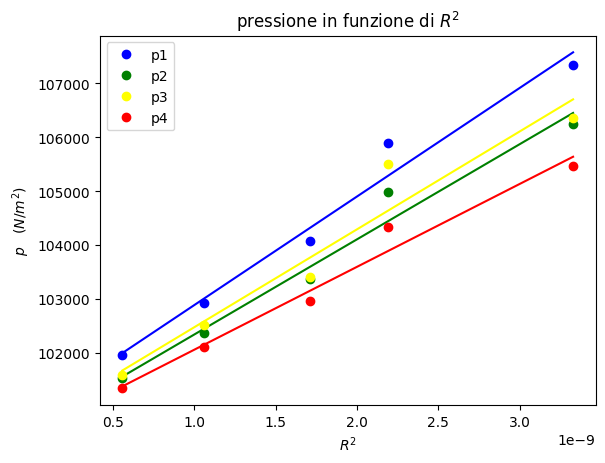

sigma p1:  405.6671586350382
sigma p2:  368.1127652706914
sigma p3:  579.7540218625944
sigma p4:  302.9080796739522


In [50]:
from interpolazione3 import RettaInterpolata

r1 = RettaInterpolata(R2,p1)
r2 = RettaInterpolata(R2,p2)
r3 = RettaInterpolata(R2,p3)
r4 = RettaInterpolata(R2,p4)

plt.title('pressione in funzione di $R^2$')
plt.errorbar(R2,p1,fmt='o',capsize=5, ecolor='black',label='p1', color='blue')
plt.errorbar(R2,p2,fmt='o',capsize=5, ecolor='black',label='p2', color='green')
plt.errorbar(R2,p3,fmt='o',capsize=5, ecolor='black',label='p3', color='yellow')
plt.errorbar(R2,p4,fmt='o',capsize=5, ecolor='black',label='p4', color='red')

plt.plot(r1.x_best,r1.y_best, color='blue')
plt.plot(r2.x_best,r2.y_best, color='green')
plt.plot(r3.x_best,r3.y_best, color='yellow')
plt.plot(r4.x_best,r4.y_best, color='red')

plt.xlabel('$R^2$')
plt.ylabel('$p \quad (N/m^2)$')
plt.legend()
plt.show()

print('sigma p1: ',r1.sigmaY)
print('sigma p2: ',r2.sigmaY)
print('sigma p3: ',r3.sigmaY)
print('sigma p4: ',r4.sigmaY)

Applichiamo le correzioni ai valori delle pressioni causati dalle turbolenze:

$P_L = P_1 \\$
$P_s = p_2 + \Delta P = P_2 + \frac{(P_1 - P_3)}{2} \\$
$P_L - P_s = P_1 - P_2 - \Delta P \\$

In [51]:
from interpolazione3 import final_val

pL, spL = p1, r1.sigmaY

ps = p2 + ((p1) - (p3))/2
sps = np.sqrt((r2.sigmaY)**2 + (0.5 * r1.sigmaY)**2 + (0.5*r3.sigmaY)**2) # usando derivate parziali

PLPs = pL - ps

sPLPs = np.average([spL,sps]) # gli errori non sono indipendenti

print('pL: ',final_val(pL,spL,decimals=0))
print('ps:',final_val(ps,sps,decimals=0))
print('pL-ps: ',final_val(PLPs,sPLPs,decimals=0))

pL:  [101960. 102920. 104080. 105890. 107340.] ± 406.0 
ps: [101720. 102570. 103705. 105185. 106730.] ± 511.0 
pL-ps:  [240. 350. 375. 705. 610.] ± 458.0 


## Verifica con equzione di Bernoulli:

$p_L - p_s = \frac{1}{2}\rho(v_s^2-v_L^2) = \frac{1}{2}\rho R^2 (\frac{1}{A_s^2} - \frac{1}{A_L^2})$

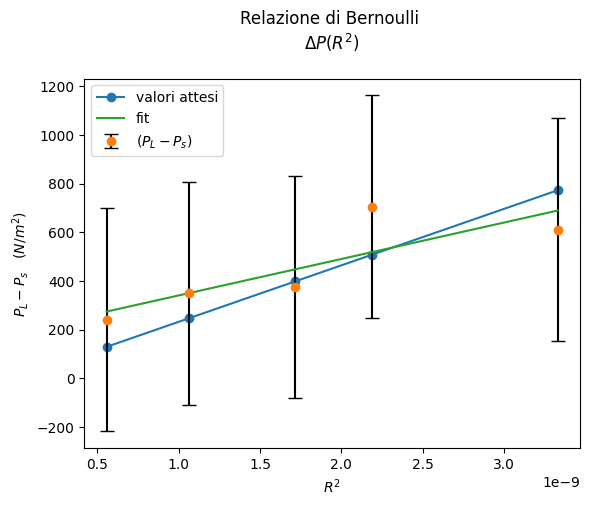


linearità A + BX
    
A: 190.837682542208 
B: 149754901023.373
sigmaA: 196.97276850480807
sigmaB: 97855669064.86563

sigmaY: 458.11633937019815    
chiquadro ridotto: 0.08
df: 3
pvalue: 99.4%
--------------------------------------------------
chi2o:  0.06546020444627278
pvalue:  99.6 %


In [52]:
import scipy.stats as sc

R2 = R**2
p_attesi = 0.5 * rho * (vs**2 - vL**2)

r = RettaInterpolata(R2,PLPs,sPLPs)

plt.title("Relazione di Bernoulli \n$\Delta P(R^2)$ \n")
plt.plot(R2,p_attesi,'o-',label='valori attesi')
plt.errorbar(R2,PLPs,fmt='o',yerr=sPLPs,capsize=5, ecolor='black',label='$(P_L - P_s)$')
plt.plot(r.x_best,r.y_best,label='fit')
plt.xlabel('$R^2$')
plt.ylabel('$P_L - P_s \quad (N / m^2)$')
plt.legend()
plt.show()

print(r)

# chiquadro e verifica adattamento dati

y = r.A + r.B * R2 # uso i valori sulla retta interpolata
chi = np.sum(((p_attesi - y)/sPLPs)**2)
df = len(R2) - 2
rchi = chi / df

print('--------------------------------------------------')
print('chi2o: ', rchi)
print('pvalue: ',np.round(sc.chi2.sf(rchi,df)*100,1),'%')
